In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download kazanova/sentiment140 -f training.1600000.processed.noemoticon.csv
!unzip /content/training.1600000.processed.noemoticon.csv.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
training.1600000.processed.noemoticon.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/training.1600000.processed.noemoticon.csv.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install transformers

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


## Loading and preprocessing dataset (1,0,-1)

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 2000) # To visualize full output

In [ ]:
url = '/content/training.1600000.processed.noemoticon.csv'
df_raw = pd.read_csv(url,encoding='latin-1',header=None)
#df_main = df_main.rename(columns = {'Zlabel':'ZLabel', 'Tlabel':'TLabel', 'text':'tweet'})
df_raw

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


In [ ]:
df = pd.DataFrame()
df['tweet'] = df_raw[5]
df['ZLabel'] = df_raw[0].replace({0:0,2:1,4:2})
df['ZLabel'].value_counts()
df = df.sample(n=50000, random_state=42)
df

,tweet,ZLabel
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps for my razr 2",0
766711,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",0
285055,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,0
705995,upper airways problem,0
...,...,...
199266,On the way home. Tired. I don't wanna babysit,0
210814,Well that was ten sneezes in a row. My allergies are not making my day easy. Still no air through the nose.,0
180674,can't go out tonight car is acting funny wat shall i do???,0
364859,Headacheeeee,0


In [ ]:
import re
def preprocess(tweet):
  tweet = tweet.replace('@ ','@').replace('# ','#')
  tweet = re.sub('pic.twitter.com.*','',tweet)
  tweet = re.sub('https*://[^\s]+','',tweet)
  tweet = re.sub('https*://.*','',tweet)
  tweet = ' '.join(w for w in tweet.split() if w[0] not in ['@']).lower()
  return tweet

In [ ]:
df['Tweet text processed'] = df['tweet'].apply(preprocess)
#print(df.head())
print('before len',len(df))
df.drop_duplicates(subset='Tweet text processed',inplace=True)
print('after len',len(df))

before len 50000
after len 49366


In [ ]:
#hindi_inds = []
df.reset_index(drop=True, inplace=True)
X = df['Tweet text processed']
y = df['ZLabel'].astype('int').replace({2:1})
#X = X.values.tolist()+append1['Tweet text processed'].values.tolist()+append2['Tweet text processed'].values.tolist()
#y = y.values.tolist()+append1['ZLabel'].values.tolist()+append2['ZLabel'].values.tolist()
#X = pd.Series(X)
#X = df['tweet']
#y = pd.Series(y).astype('int')+1
y.value_counts()

0    24748
1    24618
Name: ZLabel, dtype: int64

## Sentiment preprocess

In [ ]:
import torch

#### finding out max sent length

In [ ]:
max_len = 0
for sent in X:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  144


#### Tokenize the data

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X:
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y)

# Print sentence 0, now as a list of IDs.
print('Original: ', X.iloc[0])
print('Token IDs:', input_ids[0])

Original:  ahhh i hope your ok!!!
Token IDs: tensor([  101,  6289, 23644,  1045,  3246,  2115,  7929,   999,   999,   999,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     

#### Prepare and run the model for CV

In [ ]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
stats = {'train_loss':[None]*5, 'val_loss':[None]*5,'val_accuracy':[None]*5,
         'test_preds':[], 'test_true':[],'test_inds':[], 'test_accuracy':[None]*5}

In [ ]:
# Set the seed value all over the place to make this reproducible.
import random
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import TensorDataset
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
##################################################################################

kfOuter = StratifiedKFold(10, shuffle=True, random_state=0)
outerind = 0
dict_hyp = {}
for train_val_ind, test_ind in kfOuter.split(X, y):
  train_val_dataset = TensorDataset(input_ids[train_val_ind], 
                                    attention_masks[train_val_ind], 
                                    labels[train_val_ind])
  test_dataset = TensorDataset(input_ids[test_ind], attention_masks[test_ind], labels[test_ind])
  kfInner = StratifiedKFold(10, shuffle=True, random_state=0)
  train_ind, val_ind = next(kfInner.split(train_val_ind, labels[train_val_ind]))
  train_df_ind, val_df_ind = train_val_ind[train_ind], train_val_ind[val_ind]
  #smt = SMOTE(random_state=0)
  #inp_over,label_over = smt.fit_resample(input_ids[train_df_ind], labels[train_df_ind])
  #smt = SMOTE(random_state=0)
  #attention_over, _ = smt.fit_resample(attention_masks[train_df_ind], labels[train_df_ind])
  train_dataset = TensorDataset(input_ids[train_df_ind], attention_masks[train_df_ind], labels[train_df_ind])
  """
  train_dataset = TensorDataset(torch.LongTensor(inp_over),
                                torch.LongTensor(attention_over),
                                torch.LongTensor(label_over))
  """
  val_dataset = TensorDataset(input_ids[val_df_ind], attention_masks[val_df_ind], labels[val_df_ind])

  dict_hyp[outerind] = {}
  for epochs in [10]:
    for batch_size in [32]:
      print('epoch:batchsize',(epochs, batch_size))
      # Create the DataLoaders for our training and validation sets.
      # We'll take training samples in random order. 
      train_dataloader = DataLoader(
                  train_dataset,  # The training samples.
                  sampler = RandomSampler(train_dataset), # Select batches randomly
                  batch_size = batch_size # Trains with this batch size.
              )

      # For validation the order doesn't matter, so we'll just read them sequentially.
      validation_dataloader = DataLoader(
                  val_dataset, # The validation samples.
                  sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                  batch_size = batch_size # Evaluate with this batch size.
              )
      # Load BertForSequenceClassification, the pretrained BERT model with a single 
      # linear classification layer on top. 
      
      model = BertForSequenceClassification.from_pretrained(
          "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
          num_labels = 2, # The number of output labels--2 for binary classification.
                          # You can increase this for multi-class tasks.   
          output_attentions = False, # Whether the model returns attentions weights.
          output_hidden_states = True, # Whether the model returns all hidden-states.
      )

      # Tell pytorch to run this model on the GPU.
      model.cuda()

      # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
      # I believe the 'W' stands for 'Weight Decay fix"
      optimizer = AdamW(model.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                      )

      # Total number of training steps is [number of batches] x [number of epochs]. 
      # (Note that this is not the same as the number of training samples).
      total_steps = len(train_dataloader) * epochs

      # Create the learning rate scheduler.
      scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                  num_warmup_steps = 0, # Default value in run_glue.py
                                                  num_training_steps = total_steps)

      # Function to calculate the accuracy of our predictions vs labels
      def flat_accuracy(preds, labels):
          pred_flat = np.argmax(preds, axis=1).flatten()
          labels_flat = labels.flatten()
          return f1_score(labels_flat, pred_flat, average='macro')

      def format_time(elapsed):
          '''
          Takes a time in seconds and returns a string hh:mm:ss
          '''
          # Round to the nearest second.
          elapsed_rounded = int(round((elapsed)))
          
          # Format as hh:mm:ss
          return str(datetime.timedelta(seconds=elapsed_rounded))

      device = torch.device("cuda")
      # This training code is based on the `run_glue.py` script here:
      # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


      # We'll store a number of quantities such as training and validation loss, 
      # validation accuracy, and timings.
      training_stats = []

      # Measure the total training time for the whole run.
      total_t0 = time.time()

      embeds = []
      for epoch_i in range(0, epochs):
          
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
          #print('Training...')

          # Measure how long the training epoch takes.
          t0 = time.time()

          # Reset the total loss for this epoch.
          total_train_loss = 0

          # Put the model into training mode. Don't be mislead--the call to 
          # `train` just changes the *mode*, it doesn't *perform* the training.
          # `dropout` and `batchnorm` layers behave differently during training
          # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
          model.train()
          embed_temp = None
          # For each batch of training data...
          for step, batch in enumerate(train_dataloader):

              # Progress update every 40 batches.
              if step % 40 == 0 and not step == 0:
                  # Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  
                  # Report progress.
                  #print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              # Unpack this training batch from our dataloader. 
              #
              # As we unpack the batch, we'll also copy each tensor to the GPU using the 
              # `to` method.
              #
              # `batch` contains three pytorch tensors:
              #   [0]: input ids 
              #   [1]: attention masks
              #   [2]: labels 
              b_input_ids = batch[0].to(device)
              b_input_mask = batch[1].to(device)
              b_labels = batch[2].to(device)

              # Always clear any previously calculated gradients before performing a
              # backward pass. PyTorch doesn't do this automatically because 
              # accumulating the gradients is "convenient while training RNNs". 
              # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
              model.zero_grad()        

              # Perform a forward pass (evaluate the model on this training batch).
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # It returns different numbers of parameters depending on what arguments
              # arge given and what flags are set. For our useage here, it returns
              # the loss (because we provided labels) and the "logits"--the model
              # outputs prior to activation.
              loss, logits, hidden = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask, 
                                  labels=b_labels)

              if embed_temp == None:
                embed_temp = hidden[0][:,0,:]
              else:
                embed_temp = torch.cat([embed_temp, hidden[0][:,0,:]])
              # Accumulate the training loss over all of the batches so that we can
              # calculate the average loss at the end. `loss` is a Tensor containing a
              # single value; the `.item()` function just returns the Python value 
              # from the tensor.
              total_train_loss += loss.item()

              # Perform a backward pass to calculate the gradients.
              loss.backward()

              # Clip the norm of the gradients to 1.0.
              # This is to help prevent the "exploding gradients" problem.
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

              # Update parameters and take a step using the computed gradient.
              # The optimizer dictates the "update rule"--how the parameters are
              # modified based on their gradients, the learning rate, etc.
              optimizer.step()

              # Update the learning rate.
              scheduler.step()

          embeds.append(embed_temp)
          # Calculate the average loss over all of the batches.
          avg_train_loss = total_train_loss / len(train_dataloader)

          # Measure how long this epoch took.
          training_time = format_time(time.time() - t0)

          #print("")
          #print("  Average training loss: {0:.2f}".format(avg_train_loss))
          #print("  Training epcoh took: {:}".format(training_time))
              
          # ========================================
          #               Validation
          # ========================================
          # After the completion of each training epoch, measure our performance on
          # our validation set.

          #print("")
          #print("Running Validation...")

          t0 = time.time()

          # Put the model in evaluation mode--the dropout layers behave differently
          # during evaluation.
          model.eval()

          # Tracking variables 
          total_eval_accuracy = 0
          total_eval_loss = 0
          nb_eval_steps = 0

          val_true = []
          val_pred = []
          # Evaluate data for one epoch
          for batch in validation_dataloader:
              
              # Unpack this training batch from our dataloader. 
              #
              # As we unpack the batch, we'll also copy each tensor to the GPU using 
              # the `to` method.
              #
              # `batch` contains three pytorch tensors:
              #   [0]: input ids 
              #   [1]: attention masks
              #   [2]: labels 
              b_input_ids = batch[0].to(device)
              b_input_mask = batch[1].to(device)
              b_labels = batch[2].to(device)
              
              # Tell pytorch not to bother with constructing the compute graph during
              # the forward pass, since this is only needed for backprop (training).
              with torch.no_grad():        

                  # Forward pass, calculate logit predictions.
                  # token_type_ids is the same as the "segment ids", which 
                  # differentiates sentence 1 and 2 in 2-sentence tasks.
                  # The documentation for this `model` function is here: 
                  # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                  # Get the "logits" output by the model. The "logits" are the output
                  # values prior to applying an activation function like the softmax.
                  (loss, logits, hidden) = model(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                  
              # Accumulate the validation loss.
              total_eval_loss += loss.item()

              # Move logits and labels to CPU
              logits = logits.detach().cpu().numpy()
              label_ids = b_labels.to('cpu').numpy()

              #Z# append to val set
              val_true.extend(label_ids.tolist())
              val_pred.extend(logits.argmax(axis=1).tolist())

              # Calculate the accuracy for this batch of test sentences, and
              # accumulate it over all batches.
              total_eval_accuracy += flat_accuracy(logits, label_ids)
              

          # Report the final accuracy for this validation run.
          avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
          dict_hyp[outerind].update({(epochs, batch_size):f1_score(val_true,val_pred,average='macro')})
          print("Val F1: {0:.3f}".format(f1_score(val_true,val_pred,average='macro')))

          # Calculate the average loss over all of the batches.
          avg_val_loss = total_eval_loss / len(validation_dataloader)

          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
          
          #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
          #print("  Validation took: {:}".format(validation_time))


          # Record all statistics from this epoch.
          training_stats.append(
              {
                  'epoch': epoch_i + 1,
                  'Training Loss': avg_train_loss,
                  'Valid. Loss': avg_val_loss,
                  'Valid. Accur.': avg_val_accuracy,
                  'Training Time': training_time,
                  'Validation Time': validation_time
              }
            )

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

      del device
  outerind += 1
  break

epoch:batchsize (10, 32)
======== Epoch 1 / 10 ========


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Val F1: 0.835
======== Epoch 2 / 10 ========
Val F1: 0.834
======== Epoch 3 / 10 ========
Val F1: 0.827
======== Epoch 4 / 10 ========
Val F1: 0.828
======== Epoch 5 / 10 ========
Val F1: 0.824
======== Epoch 6 / 10 ========


In [ ]:
save_path = '/content/drive/My Drive/Scratch/'
IDM = 'Senti-140'
torch.save(model.state_dict(), save_path+IDM+'_best_model_state.bin'+'50000_epoch10')
#model.load_state_dict(torch.load(save_path+IDM+'_best_model_state.bin'+str(fold_no)))

In [ ]:
# Prepare hiddens, give them to tanmay
import pickle
embeds_np = [embed.detach().cpu().numpy() for embed in embeds]
print(len(embeds_np), embeds_np[0].shape)
with open(save_path+'Senti-140-embeds-epoch10','wb') as f:
  pickle.dump(embeds_np, f)

10 (4024, 768)


In [ ]:
import pickle
with open('hyp-hash100-oe-f1-no-over-3class.pickle','wb') as f:
    pickle.dump(dict_hyp, f)

# Run from here if hyperparameter search is over

In [ ]:
import pickle
with open('hyp-hash100-oe-f1-no-over-3class.pickle','rb') as f:
  dict_hyp = pickle.load(f)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Set the seed value all over the place to make this reproducible.
import random
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import TensorDataset
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
          pred_flat = np.argmax(preds, axis=1).flatten()
          labels_flat = labels.flatten()
          return f1_score(labels_flat, pred_flat, average='macro')

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

##############################################################################3
stats['test_inds'] = []
stats['test_preds'] = []
stats['test_preds_raw'] = []
stats['test_true'] = []
stats['test_accuracy'] = []
kfOuter = StratifiedKFold(5, shuffle=True, random_state=0)
tsta = []
trna = []
trnl = []
tstl = []
outerind = 0
f1i = 0
f1 = np.zeros((100, 3))
for train_val_ind, test_ind in kfOuter.split(X, y):
  #smt = SMOTE(random_state=0)
  #input_oversampled, labels_oversampled = smt.fit_resample(input_ids[train_val_ind], labels[train_val_ind])
  #smt = SMOTE(random_state=0)
  #attention_oversampled, _ = smt.fit_resample(attention_masks[train_val_ind], labels[train_val_ind])
  train_val_dataset = TensorDataset(input_ids[train_val_ind], attention_masks[train_val_ind], labels[train_val_ind])
  """
  train_val_dataset = TensorDataset(torch.LongTensor(input_oversampled), 
                                    torch.LongTensor(attention_oversampled), 
                                    torch.LongTensor(labels_oversampled))
  """
  test_dataset = TensorDataset(input_ids[test_ind], attention_masks[test_ind], labels[test_ind])
  kfInner = StratifiedKFold(5, shuffle=True, random_state=0)
  train_ind, val_ind = next(kfInner.split(train_val_ind, labels[train_val_ind]))
  train_df_ind = train_val_ind[train_ind]
  val_df_ind = train_val_ind[val_ind]
  #smt = SMOTE(random_state=0)
  #input_oversampled, labels_oversampled = smt.fit_resample(input_ids[train_df_ind], labels[train_df_ind])
  #smt = SMOTE(random_state=0)
  #attention_oversampled, _ = smt.fit_resample(attention_masks[train_df_ind], labels[train_df_ind])
  """
  train_dataset =  TensorDataset(torch.LongTensor(input_oversampled), 
                                    torch.LongTensor(attention_oversampled), 
                                    torch.LongTensor(labels_oversampled))
  """
  train_dataset = TensorDataset(input_ids[train_df_ind], attention_masks[train_df_ind], labels[train_df_ind])
  
  epochs, batch_size = max(dict_hyp[outerind], key=lambda x: dict_hyp[outerind][x])
  #epochs, batch_size = 4, 32
  print('epoch:batchsize',(epochs, batch_size))
  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_val_dataset,  # The training samples.
              sampler = RandomSampler(train_val_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  test_dataloader = DataLoader(
              test_dataset, # The validation samples.
              sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 3, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.cuda()

  # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
  # I believe the 'W' stands for 'Weight Decay fix"
  optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)

  device = torch.device("cuda")
  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      #print("")
      #print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      #print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      train_true = []
      train_pred = []
      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              #print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          loss, logits = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)
          
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()  
          train_true.extend(label_ids.tolist())
          train_pred.extend(logits.argmax(axis=1).tolist())
          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)
      trnl.append(avg_train_loss)
      trna.append(f1_score(train_true, train_pred, average='macro'))
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      #print("")
      #print("  Average training loss: {0:.2f}".format(avg_train_loss))
      #print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      #print("")
      #print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      val_true = []
      val_pred = []
      val_pred_raw = []
      # Evaluate data for one epoch
      for batch in test_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          import tensorflow as tf
          #Z# append to val set
          val_true.extend(label_ids.tolist())
          val_pred.extend(logits.argmax(axis=1).tolist())
          val_pred_raw.extend(tf.nn.softmax(logits).numpy().max(axis=1).tolist())

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
      
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(test_dataloader)
      tstl.append(avg_val_loss)
      tsta.append(f1_score(val_true, val_pred, average='macro'))
      f1[f1i,:] = f1_score(val_true, val_pred, average=None)
      f1i += 1
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      #print("  Validation took: {:}".format(validation_time))


      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
        )
  stats['test_inds'].extend(test_ind)
  
  stats['test_preds'].extend(val_pred)
  
  stats['test_true'].extend(val_true)
  stats['test_preds_raw'].extend(val_pred_raw)
  stats['test_accuracy'].append(f1_score(val_true, val_pred, average='macro'))
  print("")
  print("Training complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  del device
  outerind += 1

epoch:batchsize (15, 4)
  Accuracy: 0.28
  Accuracy: 0.38
  Accuracy: 0.47
  Accuracy: 0.62
  Accuracy: 0.50
  Accuracy: 0.66
  Accuracy: 0.61
  Accuracy: 0.60
  Accuracy: 0.58
  Accuracy: 0.54
  Accuracy: 0.58
  Accuracy: 0.58
  Accuracy: 0.58
  Accuracy: 0.58
  Accuracy: 0.58

Training complete!
Total training took 0:00:43 (h:mm:ss)
epoch:batchsize (8, 8)
  Accuracy: 0.34
  Accuracy: 0.45
  Accuracy: 0.45
  Accuracy: 0.49
  Accuracy: 0.60
  Accuracy: 0.52
  Accuracy: 0.54
  Accuracy: 0.54

Training complete!
Total training took 0:00:12 (h:mm:ss)
epoch:batchsize (15, 4)
  Accuracy: 0.27
  Accuracy: 0.27
  Accuracy: 0.38
  Accuracy: 0.57
  Accuracy: 0.66
  Accuracy: 0.60
  Accuracy: 0.53
  Accuracy: 0.61
  Accuracy: 0.54
  Accuracy: 0.57
  Accuracy: 0.54
  Accuracy: 0.57
  Accuracy: 0.57
  Accuracy: 0.53
  Accuracy: 0.53

Training complete!
Total training took 0:00:30 (h:mm:ss)
epoch:batchsize (9, 4)
  Accuracy: 0.35
  Accuracy: 0.39
  Accuracy: 0.37
  Accuracy: 0.46
  Accuracy: 0.41
 

In [ ]:
# Verification of train-val-test splits
total = train_df_ind.tolist() + val_df_ind.tolist() + test_ind.tolist()
sorted(total) == list(range(len(total)))

True

In [ ]:
import matplotlib.pyplot as plt
"""
fig, ax = plt.subplots(5,1,figsize=(10,15))
plt.title('Accuracy')
for i in range(5):
    ax[i].plot(range(50), tsta[i*50:(i+1)*50], label='test accuracy')
    ax[i].plot(range(50), trna[i*50:(i+1)*50], label='train accuracy')
    ax[i].legend()
plt.show()

eps = 4
fig, ax = plt.subplots(5,1,figsize=(10,15))
plt.title('Loss')
for i in range(5):
    ax[i].plot(range(eps), tstl[i*eps:(i+1)*eps], label='test loss')
    ax[i].plot(range(eps), trnl[i*eps:(i+1)*eps], label='train loss')
    ax[i].plot(range(eps), tsta[i*eps:(i+1)*eps], label='test accuracy')
    ax[i].legend()
plt.show()

fig, ax = plt.subplots(5,1,figsize=(10,15))
plt.title('Accuracy')
old = 0
for i in range(5):
    new = max(dict_hyp[i], key=lambda x: dict_hyp[i][x])[0]
    ax[i].plot(range(new-old), trna[old:new], label='train accuracy', color='k')
    ax[i].plot(range(new-old), f1[old:new,0], label='-1')
    ax[i].plot(range(new-old), f1[old:new,1], label='0')
    ax[i].plot(range(new-old), f1[old:new,2], label='1')
    ax[i].legend()
    old = new
plt.show()
"""

"\nfig, ax = plt.subplots(5,1,figsize=(10,15))\nplt.title('Accuracy')\nfor i in range(5):\n    ax[i].plot(range(50), tsta[i*50:(i+1)*50], label='test accuracy')\n    ax[i].plot(range(50), trna[i*50:(i+1)*50], label='train accuracy')\n    ax[i].legend()\nplt.show()\n\neps = 4\nfig, ax = plt.subplots(5,1,figsize=(10,15))\nplt.title('Loss')\nfor i in range(5):\n    ax[i].plot(range(eps), tstl[i*eps:(i+1)*eps], label='test loss')\n    ax[i].plot(range(eps), trnl[i*eps:(i+1)*eps], label='train loss')\n    ax[i].plot(range(eps), tsta[i*eps:(i+1)*eps], label='test accuracy')\n    ax[i].legend()\nplt.show()\n\nfig, ax = plt.subplots(5,1,figsize=(10,15))\nplt.title('Accuracy')\nold = 0\nfor i in range(5):\n    new = max(dict_hyp[i], key=lambda x: dict_hyp[i][x])[0]\n    ax[i].plot(range(new-old), trna[old:new], label='train accuracy', color='k')\n    ax[i].plot(range(new-old), f1[old:new,0], label='-1')\n    ax[i].plot(range(new-old), f1[old:new,1], label='0')\n    ax[i].plot(range(new-old), f1

### Confusion Matrix

In [ ]:
!pip -q install matplotlib==3.1.0

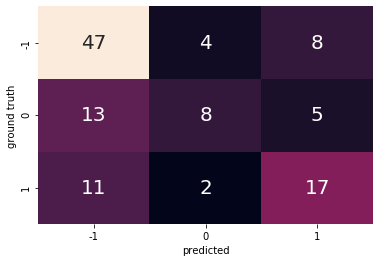

array([[47,  4,  8],
       [13,  8,  5],
       [11,  2, 17]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = [[29,17,17],[6,112,27],[16,20,102]][::-1]
sns.heatmap(np.flipud(confusion_matrix(stats['test_true'], stats['test_preds'])),
            fmt = '.3g',
            annot=True,annot_kws={"size": 20},cbar=False,
            xticklabels=[-1,0,1],
            yticklabels=[1,0,-1])
plt.xlabel('predicted')
plt.ylabel('ground truth')
plt.ylim([0,3])
plt.show()
confusion_matrix(stats['test_true'], stats['test_preds'])

In [ ]:
print(f1_score(stats['test_true'], stats['test_preds'], average='macro'))
print(f1_score(stats['test_true'], stats['test_preds'], average=None))
print(classification_report(np.array(stats['test_true'])-1, np.array(stats['test_preds'])-1))
print(stats['test_accuracy'])
print(np.mean(stats['test_accuracy']))
#stats
import pickle
#with open('/content/drive/My Drive/Twitter+AQ project/SentimentAnalysis/5fold-hyp.pickle','wb') as f:
#  pickle.dump(stats, f)
#with open('/content/sample_data/test.pickle','wb') as f:
#  pickle.dump(stats['test_inds'],f)

0.5632478632478632
[0.72307692 0.4        0.56666667]
              precision    recall  f1-score   support

          -1       0.66      0.80      0.72        59
           0       0.57      0.31      0.40        26
           1       0.57      0.57      0.57        30

    accuracy                           0.63       115
   macro avg       0.60      0.56      0.56       115
weighted avg       0.62      0.63      0.61       115

[0.5994939038417298, 0.524731182795699, 0.6071428571428572, 0.5641025641025642, 0.4551282051282051]
0.5501197426022111


In [ ]:
dfold = df.copy()
df = df.reindex(stats['test_inds'])
df['pred'] = np.array(stats['test_preds'])-1
df['pred_raw'] = np.array(stats['test_preds_raw'])

In [ ]:
df[df['ZLabel'] == df['pred']][['Tweet text processed','ZLabel','pred','pred_raw']]

,Tweet text processed,ZLabel,pred,pred_raw
18,"not at all a # bjp bhakt, but gautamgambhir is right when he says he has deployed water sprinklers, vacuum cleaner worth 90 cr to reduce pollution and what has arvindkejriwal.. # oddeven scheme marketing budget is a cruel joke, with no longtime results",-1.0,-1,0.985436
23,"awesome, so aqi back to 'very poor', well, # oddeven # oddevenscheme seems to be a huge success # delhiairemergency # delhiairpollution # delhincrpollution # delhipollution pandyaaabhas pashyantii",1.0,1,0.570918
27,"gautamgambhir sir, do you think odd-even is gimmick ? please explain how ? i request please give logical reasoning when you reply. # delhiairemergency # delhincrpollution # delhi # oddevenscheme # oddeven # carpoolsupporter # carpooling",0.0,0,0.498259
30,the state of delhi is that of a climate emergency. the national capital can no longer get away with gimmick like # oddeven & banning construction sites. we need long term sustainable solutions & stop the blame game. it's time to own up & act responsibly: # gautamgambhir (ani)pic.twitter.com/drux6toyqq,-1.0,-1,0.982400
33,arvindkejriwal you did 1 thing good by getting # oddeven started. please get this continued. we need air to breathe and road to travel and walk as well. # delhiairpollution # trafficupdates dtptraffic do something about dhaula kuan round about.,1.0,1,0.890536
...,...,...,...,...
96,"# oddeven great efforts, pls keep it up..",1.0,1,0.542126
99,"considering the # smog condition in delhi, can we just increase the # oddeven for few more days. it certainly makes the impact & helps big time. dear arvindkejriwal aamaadmiparty can u please help for # extendoddeven in delhi. thanks",1.0,1,0.512260
104,# oddeven. useless scheme which allows most polluting 2 wheelers while banning cng vehicles.,-1.0,-1,0.895400
108,oddeven seems to be a fund collection activity as other than smooth traffic there is no environment improvement. are we so desperate to show our power? aamaadmiparty arvindkejriwal narendramodi pmoindia # oddeven # delhiairpollution ltgovdelhi incdelhi toiindianewshttps://twitter.com/9vinie/status/1194879969710624768 …,-1.0,-1,0.668576


In [ ]:
#for outerind in range(5):
#    print(max(dict_hyp[outerind], key=lambda x: dict_hyp[outerind][x]))

### Visualize wrongly predicted results

In [ ]:
df[df['ZLabel'] != df['pred']][['Tweet text processed','ZLabel','pred','pred_raw']]

,Tweet text processed,ZLabel,pred,pred_raw
0,"is it odd or even day, manakgupta? # oddeven",0.0,1,0.804356
41,did # delhincr activate some cheat code? # aqi # oddeven pleasantly surprised though!,1.0,-1,0.854099
67,"we asked our followers whether # oddeven policy is effective and should be extended. out of 350 responses, 43% people think that # oddevenscheme is effective and should be extended while 57% don't find it effective. # delhiairpollution # delhipollutionpic.twitter.com/ptrj2u4goq",0.0,-1,0.646709
84,"# oddeven is half baked, need long term solutions: # supremecourthttps://www.gonewsindia.com/latest-news/news-and-politics/odd-even-is-half-baked-need-long-term-solutions-sc-4315 …",-1.0,0,0.745083
107,# oddeven not helping arvindkejriwal . # delhiairemergency # delhiairpollution # delhiairquality narendramodi priyankagandhi rahulgandhi prakashjavdekar capt_amarinder mlkhattarpic.twitter.com/vj9g3wkejk,-1.0,0,0.875449
114,this is clearly stated by cpcb data that pollution level on most # oddeven days have come down from last year. arvindkejriwal msisodia …pic.twitter.com/jycxc4ou0x,1.0,-1,0.773404
28,absolutely; # oddeven can go a long way in tackling traffic chaos as well as # pollution on some long term basis,1.0,-1,0.741348
40,those questioning did # oddeven help bring down air # pollution ? after # oddeven average decrease in aqi *delhi > 41 points *ghaziabad > 13.3 *noida > 12.3 most improvement seen in delhi …,1.0,-1,0.536983
50,but why don't # delhi # aap # mla voluntarily follow # oddeven throughout the year ? what say bjp4delhi kapilmishra_ind tajinderbagga ?,0.0,-1,0.928594
57,"not against # oddeven scheme"", says manoj tiwari. …pic.twitter.com/bnc0qv4y37""",0.0,-1,0.653571


In [ ]:
df.to_csv('100oe-f1-no-over-3class.csv')